In [1]:
import numpy as np
import copy
import netCDF4 as nc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import esmpy as ESMF
from scipy import stats
import xarray as xr

In [2]:
def get_model_ds(src_model):
    
    # CONSTRUCT FILE NAME
    ncfil = (mod_dict[src_model]['dir'] 
            + mod_dict[src_model]['fil_pre']
            + seasons_dict[seas]
            + mod_dict[src_model]['fil_suf']
            + '.nc')
            
    print(ncfil)
            
    # Open as xarray dataset
    ds = xr.open_dataset((ncfil),decode_times=False)
        
    return ds
                

In [3]:
def create_regrid_obj():
    # ESACCI is higher resolution than NEP so ESACCI is source; NEP is destination
    
    sourcegrid = ESMF.Grid(np.array((len(lat),len(lon))), staggerloc = ESMF.StaggerLoc.CORNER,coord_sys = ESMF.CoordSys.SPH_DEG)
    sourcegrid.add_item(ESMF.GridItem.MASK,[ESMF.StaggerLoc.CENTER])
    grid_mask = sourcegrid.get_item(ESMF.GridItem.MASK)
    #grid_mask[...] = lsm.astype(np.int32)

    source_lon = sourcegrid.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    source_lat = sourcegrid.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)

    Xn, Yn = np.meshgrid(clon,clat)
    
    source_lon[...] = Xn
    source_lat[...] = Yn

    sourcefield = ESMF.Field(sourcegrid, name = 'ESACCI data')
    srcfracfield = ESMF.Field(sourcegrid, 'srcfracfield')
    
    destgrid = ESMF.Grid(np.array(nep_lon.shape), staggerloc = ESMF.StaggerLoc.CORNER, coord_sys = ESMF.CoordSys.SPH_DEG)

    dest_lon = destgrid.get_coords(0,staggerloc=ESMF.StaggerLoc.CORNER)
    dest_lat = destgrid.get_coords(1,staggerloc=ESMF.StaggerLoc.CORNER)

    dest_lon[...] = nep_clon
    dest_lat[...] = nep_clat

    destfield = ESMF.Field(destgrid, name = 'NEP grid')

    # DEFINE INTERPOLATION FUNCTION
    regrid = ESMF.Regrid(sourcefield, destfield,regrid_method = ESMF.RegridMethod.CONSERVE,
                     src_mask_values=np.array([0], dtype=np.int32),src_frac_field=srcfracfield,
                     norm_type=ESMF.NormType.FRACAREA,unmapped_action = ESMF.UnmappedAction.IGNORE)
    
    return sourcefield, destfield, regrid


In [4]:
def plot_map(var_val,clat,clon,vmin,vmax,cmap,norm,c_inc):
    
    ax = fig.add_subplot(spec[nsea,ncol], projection=ccrs.PlateCarree(central_longitude=-100))

    C = ax.pcolormesh(clon,clat,var_val, transform=ccrs.PlateCarree(),
                      cmap=cmap, norm=norm)
    
    if ncol == 3:
        levels = np.array([-np.log10(2),np.log10(2)])
        CS = ax.contour(nep_lon,nep_lat,var_val,levels, colors='k', transform=ccrs.PlateCarree())
    #levels = np.arange(vmin,vmax+c_inc/2,c_inc)
    #CS = ax.contour(nep_lon,nep_lat,var_val,levels, colors='k', transform=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.LAND,color='blanchedalmond',zorder=50)
    ax.coastlines(zorder=50)
    outline_nep_domain(ax,nep_clon,nep_clat)
            
    # ADDING GRID LINES AND GRID LABELS
    gl = ax.gridlines(draw_labels=True)
    
    gl.xlocator = mticker.FixedLocator([180, -150, -120])
    gl.ylocator = mticker.FixedLocator([25, 55])
    
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}

   
    gl.top_labels = False
    gl.bottom_labels = False
    gl.left_labels = False
    gl.right_labels = False    
        

    plt.setp(ax.spines.values(), linewidth=2,zorder=100)
    
    # COLORBARS
    if nsea == 3:
        gl.bottom_labels = True
        pos = ax.get_position()
        if ncol == 0:
            cax = fig.add_axes([pos.x0, pos.y0-.3*pos.height, 2*pos.width, .1*pos.height])
            cbar = plt.colorbar(C,cax=cax,orientation='horizontal',extend='both')
            cbar.ax.tick_params(labelsize=16)
            cax.set_xlabel((chl_dict[transform]['cbar_tit'] + ' [Chlorophyll]' + chl_dict[transform]['units']),fontsize=20)
            
        elif ncol == 3:
            
            cax = fig.add_axes([pos.x0, pos.y0-.3*pos.height, pos.width, .1*pos.height])
            cbar = plt.colorbar(C,cax=cax,orientation='horizontal',extend='both')
            #cbar.ax.locator_params(nbins=5)
            cax.plot([levels[levels>=0]]*2, [0, 1], 'k')
            cax.plot([levels[levels<0]]*2, [0, 1], '--k')
            cbar.ax.set_xticks(chl_dict[transform]['cbar_xticks'],)
            #cbar.ax.set_xticklabels([-2,-.5,-.1,0,.1,.5,2])
            cbar.ax.tick_params(labelsize=16)
            cax.set_xlabel((r'$\Delta$ ' + chl_dict[transform]['cbar_tit'] + ' [Chlorophyll] ' + chl_dict[transform]['units']),fontsize=20)
    
    # Labels
    if ncol == 0:
        gl.left_labels = True
        plt_lab = seasons_dict[seas]  
        ax.text(243.0, 56, plt_lab, transform=ccrs.PlateCarree(), fontsize=25, ha='center', zorder=53)
    elif (ncol == 3) & (calc_stats==True):
        ax.text(.03, .05, ('Bias: ' + f'{amean_bias:.2f}' + '\nRMSE: ' + f'{armse:.2f}' + '\nMedAE: ' + f'{medae:.2f}' + '\nR: ' + f'{corr[0]:.2f}'), 
            ha="left", va="bottom", size=26, 
            bbox=stats_box_props,transform=ax.transAxes)
     # Titles
    if nsea == 0:
        if ncol == 0:
            title_text = 'NEP10k'
        elif ncol == 1:
            title_text = 'OC-CCI'
        else:
            title_text = 'NEP10k - OC-CCI'
        
        ax.set_title(title_text, fontsize=28)
        
    # Subplot label    
    ax.text(160,65, plot_labels[nlab], fontsize=25, ha='center', va='center',
            transform=ccrs.PlateCarree(),zorder=55)          
    # SET AXES EXTENT
    ax.set_extent([np.min(nep_clon),np.max(nep_clon),
                   np.min(nep_clat),70], crs=ccrs.PlateCarree())  
    plt.draw()

In [5]:
def calc_stats_vals():
    
    # CALCULATE STATISTICS
    domain_chl_dif = np.nanmean(chl_dif,axis=0)
    not_nan_idx = ~np.isnan(domain_chl_dif)
    
    # Mean Bias
    mean_bias = np.mean(domain_chl_dif[not_nan_idx])
    print('MEAN BIAS:', mean_bias)

    # Mean Bias Area Weighted
    amean_bias = np.sum((domain_chl_dif*nep_area)[not_nan_idx])/np.sum(nep_area[not_nan_idx])
    print('AREA-WEIGHTED MEAN BIAS:', amean_bias)

    # RMSE 
    rmse = np.sqrt(np.mean(((domain_chl_dif)**2)[not_nan_idx]))
    print('RMSE:', rmse)

    # RMSE Area weighted
    armse = np.sqrt(np.sum((((domain_chl_dif)**2)*nep_area)[not_nan_idx])/np.sum(nep_area[not_nan_idx]))
    print('AREA-WEIGHTED RMSE:', armse)

    # Median absolute error
    medae = np.nanmedian(np.abs(domain_chl_dif)[not_nan_idx])
    print('MEDIAN ABSOLUTE ERROR:', medae)

    # Correlation
    #nan_idx = ~np.isnan(slope_nep.ravel())*~np.isnan(slope_comp.ravel())
    corr = stats.pearsonr(np.nanmean(NEP_chl,axis=0)[not_nan_idx].ravel(), np.nanmean(ESA_val_out_store,axis=0)[not_nan_idx].ravel())
    print('CORRELATION:', corr)

    return mean_bias, amean_bias, rmse, armse, medae, corr

In [6]:
def outline_nep_domain(ax,clon,clat):
    #NEP DOMAIN OUTLINE
    lin_col = 'dimgrey'
    ax.plot(clon[0,:],clat[0,:],linewidth=1.5,color=lin_col,transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,0],clat[:,0],linewidth=1.5,color=lin_col,transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[-1,:],clat[-1,:],linewidth=1.5,color=lin_col,transform=ccrs.PlateCarree(),zorder=42)
    ax.plot(clon[:,-1],clat[:,-1],linewidth=1.5,color=lin_col,transform=ccrs.PlateCarree(),zorder=42)
        

In [7]:
def get_coords(src_model,ds):
 
    if src_model == 'ESA':
        
        lon = ds.lon.values
        lat = ds.lat.values
        lon_dif = abs(np.diff(lon))
        clon = [lon[0]-lon_dif[0]] + ((lon[:-1]+lon[1:])/2).tolist() + [lon[-1]+lon_dif[-1]]
        lat_dif = abs(np.diff(lat))
        clat = [lat[0]+lat_dif[0]] + ((lat[:-1]+lat[1:])/2).tolist() + [lat[-1]-lat_dif[-1]]
        
    elif src_model == 'NEP':
 
        lon = nep_lon
        lat = nep_lat
        clon = nep_clon 
        clat = nep_clat

    return lat,lon,clat,clon
                

In [8]:
# NEP Grid
nep_grd_fil = '/work/role.medgrp/NEP/plotting/shared_files/NEP_ocean_static_nomask.nc'
grd_fid = nc.Dataset(nep_grd_fil)

# Extracting tracer lat/lon from the supergrid
nep_lat = grd_fid.variables['geolat'][:]
nep_lon = grd_fid.variables['geolon'][:]

# Extracting tracer corner lat/lon from the supergrid - needed for regridding and pcolor plots
nep_clat = grd_fid.variables['geolat_c'][:]
nep_clon = grd_fid.variables['geolon_c'][:]

nep_topo = grd_fid.variables['deptho'][:]

lsm = grd_fid.variables['wet'][:]
lsm[lsm<1]=0 
lsm[lsm>1]=1 

nep_area = grd_fid.variables['areacello'][:].squeeze()
nep_area[lsm<.5]=0

chuk_mask = nep_lat>66

In [9]:
mod_dict = {'ESA':{'dir':'/work/role.medgrp/NEP/plotting/Figure_10/',
                   'fil_pre':'ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-',
                   'fil_suf':'-fv6.0_nep',
                   },
            
            'NEP':{'dir':'/work/role.medgrp/NEP/plotting/Figure_10/',
                   'fil_suf':'_ts',}}
            
seasons_dict = {'Winter': 'JFM', 
                'Spring': 'AMJ', 
                'Summer': 'JAS', 
                'Fall':   'OND'}

chl_dict = {'abs':{'vmin':0,'vmax':2, 'cbar_n':17, 'inc':.25,
                   'cbar_tit':'abs', 'units':' (mg m$^{-3}$)','cbar_xticks':[-2,-.5,-.1,0,.1,.5,2],
                   'dif_range':1, 'dif_cbar_n':17,'dif_inc':.125},
            'log':{'vmin':-1.1,'vmax':0.9, 'cbar_n':17, 'inc':.1,
                   'cbar_tit':'log$_{10}$', 'units':'','cbar_xticks':np.linspace(-np.log10(4),np.log10(4),5),
                   'dif_range':np.log10(4), 'dif_cbar_n':17,'dif_inc':.25}}

plot_labels = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r']


/work/role.medgrp/NEP/plotting/Figure_10/ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-JFM-fv6.0_nep.nc
MEEP


/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/98441671.py:4: RuntimeWarning: Mean of empty slice
  domain_chl_dif = np.nanmean(chl_dif,axis=0)
/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/98441671.py:29: RuntimeWarning: Mean of empty slice
  corr = stats.pearsonr(np.nanmean(NEP_chl,axis=0)[not_nan_idx].ravel(), np.nanmean(ESA_val_out_store,axis=0)[not_nan_idx].ravel())


MEAN BIAS: 0.10993166601418493
AREA-WEIGHTED MEAN BIAS: 0.09740611420119547
RMSE: 0.24349788128650976
AREA-WEIGHTED RMSE: 0.23313363282553132
MEDIAN ABSOLUTE ERROR: 0.12299279518605985
CORRELATION: PearsonRResult(statistic=0.8030181307388904, pvalue=0.0)
log : 16.912841454927765 -1.5378480333342675
log : 0.7676742054402954 -1.4740669962720894


/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/577782496.py:87: RuntimeWarning: Mean of empty slice
  plot_map(np.nanmean(NEP_chl,axis=0),nep_clat,nep_clon,
/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/577782496.py:97: RuntimeWarning: Mean of empty slice
  plot_map(np.nanmean(ESA_chl,axis=0),clat,clon,
/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/577782496.py:105: RuntimeWarning: Mean of empty slice
  plot_map(np.nanmean(chl_dif,axis=0),nep_clat,nep_clon,



/work/role.medgrp/NEP/plotting/Figure_10/ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-AMJ-fv6.0_nep.nc
MEEP


/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/98441671.py:4: RuntimeWarning: Mean of empty slice
  domain_chl_dif = np.nanmean(chl_dif,axis=0)
/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/98441671.py:29: RuntimeWarning: Mean of empty slice
  corr = stats.pearsonr(np.nanmean(NEP_chl,axis=0)[not_nan_idx].ravel(), np.nanmean(ESA_val_out_store,axis=0)[not_nan_idx].ravel())


MEAN BIAS: 0.1824534108906962
AREA-WEIGHTED MEAN BIAS: 0.1831404814432846
RMSE: 0.25461617962186744
AREA-WEIGHTED RMSE: 0.250156851891994
MEDIAN ABSOLUTE ERROR: 0.2070314057440034
CORRELATION: PearsonRResult(statistic=0.947301682742707, pvalue=0.0)
log : 16.150252662375664 -2.05920288218463
log : 1.108764370256706 -1.8769333421019947


/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/577782496.py:87: RuntimeWarning: Mean of empty slice
  plot_map(np.nanmean(NEP_chl,axis=0),nep_clat,nep_clon,
/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/577782496.py:97: RuntimeWarning: Mean of empty slice
  plot_map(np.nanmean(ESA_chl,axis=0),clat,clon,
/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/577782496.py:105: RuntimeWarning: Mean of empty slice
  plot_map(np.nanmean(chl_dif,axis=0),nep_clat,nep_clon,



/work/role.medgrp/NEP/plotting/Figure_10/ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-JAS-fv6.0_nep.nc
MEEP


/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/98441671.py:4: RuntimeWarning: Mean of empty slice
  domain_chl_dif = np.nanmean(chl_dif,axis=0)
/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/98441671.py:29: RuntimeWarning: Mean of empty slice
  corr = stats.pearsonr(np.nanmean(NEP_chl,axis=0)[not_nan_idx].ravel(), np.nanmean(ESA_val_out_store,axis=0)[not_nan_idx].ravel())


MEAN BIAS: 0.1688692525427225
AREA-WEIGHTED MEAN BIAS: 0.1707620592237626
RMSE: 0.25317859418837163
AREA-WEIGHTED RMSE: 0.2526557660911111
MEDIAN ABSOLUTE ERROR: 0.1818165499137942
CORRELATION: PearsonRResult(statistic=0.9367471195989894, pvalue=0.0)
log : 14.22526335366805 -1.7028399326575485
log : 1.1092687479495293 -1.604758502200577


/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/577782496.py:87: RuntimeWarning: Mean of empty slice
  plot_map(np.nanmean(NEP_chl,axis=0),nep_clat,nep_clon,
/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/577782496.py:97: RuntimeWarning: Mean of empty slice
  plot_map(np.nanmean(ESA_chl,axis=0),clat,clon,
/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/577782496.py:105: RuntimeWarning: Mean of empty slice
  plot_map(np.nanmean(chl_dif,axis=0),nep_clat,nep_clon,



/work/role.medgrp/NEP/plotting/Figure_10/ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-OND-fv6.0_nep.nc
MEEP


/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/98441671.py:4: RuntimeWarning: Mean of empty slice
  domain_chl_dif = np.nanmean(chl_dif,axis=0)
/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/98441671.py:29: RuntimeWarning: Mean of empty slice
  corr = stats.pearsonr(np.nanmean(NEP_chl,axis=0)[not_nan_idx].ravel(), np.nanmean(ESA_val_out_store,axis=0)[not_nan_idx].ravel())


MEAN BIAS: 0.09618364638151365
AREA-WEIGHTED MEAN BIAS: 0.08218579707946229
RMSE: 0.22196859042909697
AREA-WEIGHTED RMSE: 0.21132870190101044
MEDIAN ABSOLUTE ERROR: 0.14201167092834588
CORRELATION: PearsonRResult(statistic=0.9156446413383081, pvalue=0.0)
log : 8.706614634098244 -1.4029664960348316
log : 0.6276132779232385 -1.402291608940199


/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/577782496.py:87: RuntimeWarning: Mean of empty slice
  plot_map(np.nanmean(NEP_chl,axis=0),nep_clat,nep_clon,
/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/577782496.py:97: RuntimeWarning: Mean of empty slice
  plot_map(np.nanmean(ESA_chl,axis=0),clat,clon,
/vftmp/Utheri.Wagura/pid28791/ipykernel_2816/577782496.py:105: RuntimeWarning: Mean of empty slice
  plot_map(np.nanmean(chl_dif,axis=0),nep_clat,nep_clon,


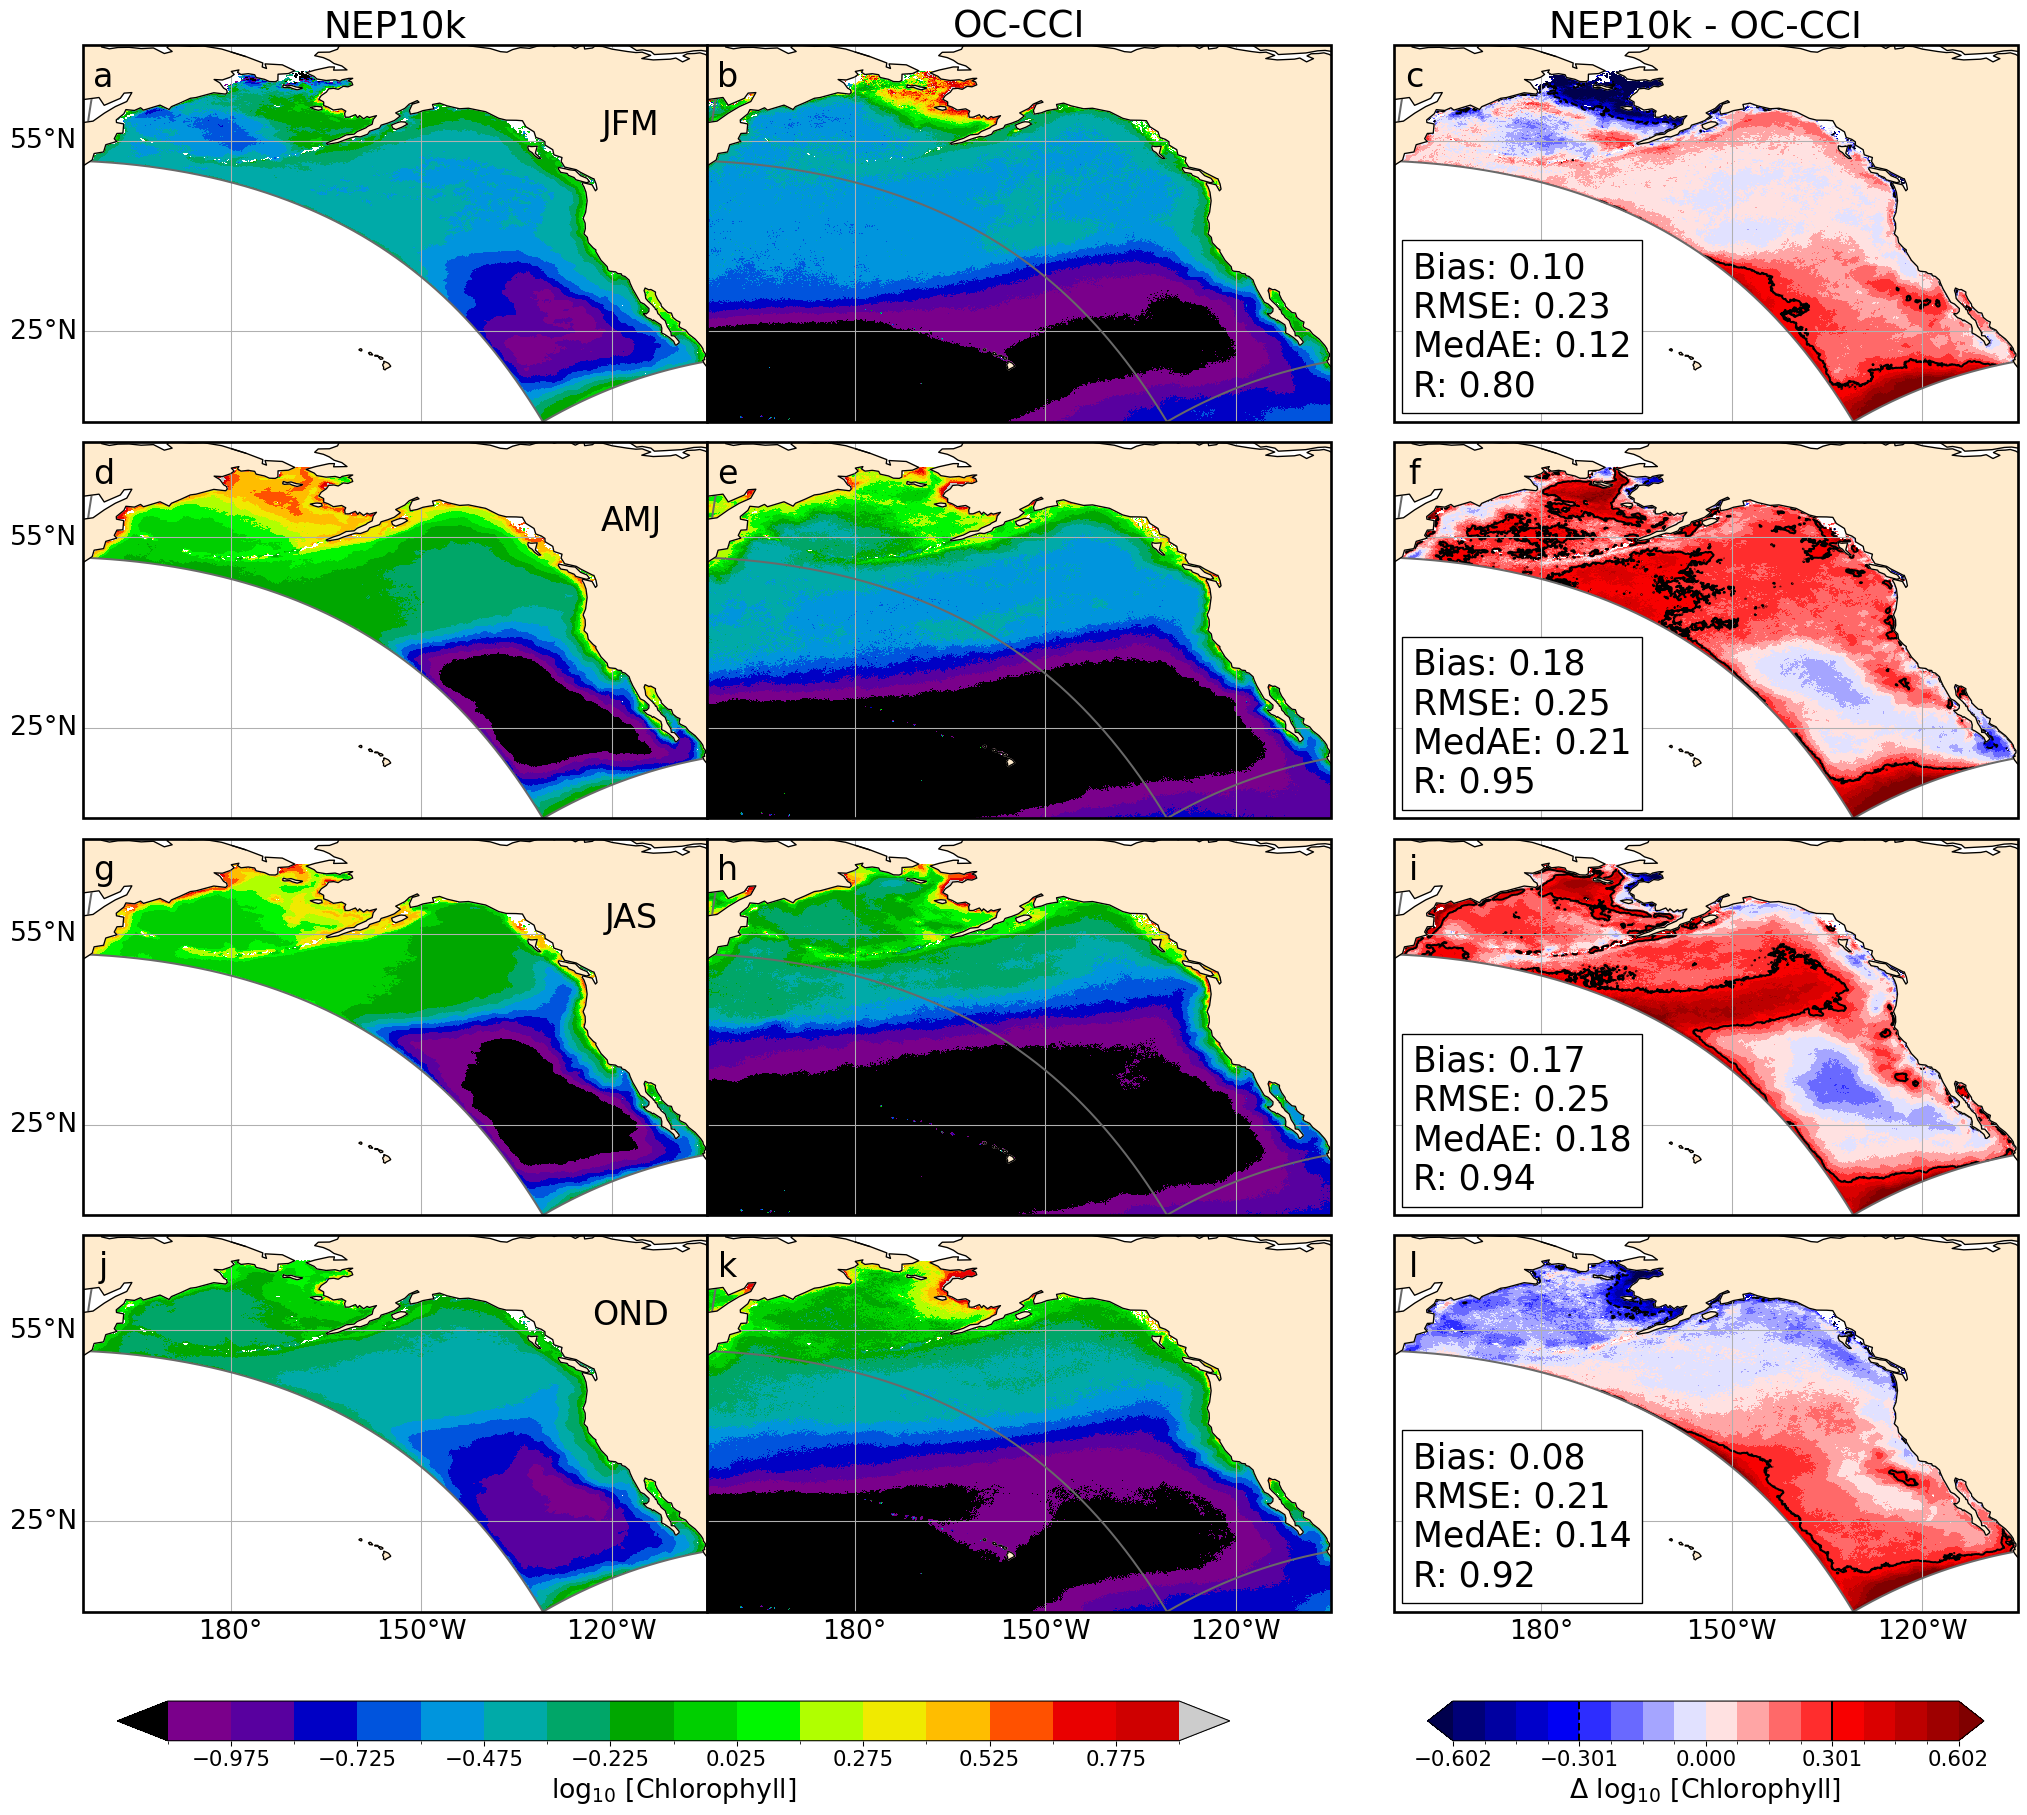

In [10]:
fil_dir = '/work/role.medgrp/NEP/plotting/Figure_10/'

heights = [10,10,10,10,1]
widths = [10,10, 1,10]

fig = plt.figure(figsize=(26,22),dpi=96)
spec = fig.add_gridspec(ncols=4, nrows=5,wspace=0,hspace=0.,height_ratios=heights, width_ratios=widths)  
stats_box_props = dict(boxstyle="square", fc="w", ec="0.0", alpha=1)
#transform = 'abs'
transform = 'log'
assign_coords=True
make_regridder=True
calc_stats = True

# Colorbars
cmap1 = mpl.cm.nipy_spectral
cmap2 = mpl.cm.seismic
norm2 = mcolors.SymLogNorm(linthresh=0.1,vmin=-2.0, vmax=2.0)
norm=mcolors.LogNorm(vmin=0.05,vmax=5)

bounds = np.linspace(chl_dict[transform]['vmin'],chl_dict[transform]['vmax'],17)
norm3 = mcolors.BoundaryNorm(bounds, cmap1.N, extend='both')

bounds = np.linspace(-chl_dict[transform]['dif_range'],chl_dict[transform]['dif_range'],17)
norm4 = mcolors.BoundaryNorm(bounds, cmap2.N, extend='both')
nlab=0

for seas, nsea in zip(seasons_dict,range(len(seasons_dict))):
    ncol = 0
    ncfil = fil_dir + 'nep_chlos_1998-2019_' + seasons_dict[seas] + '_ts.nc'
    
    # Open as xarray dataset
    ds = xr.open_dataset((ncfil),decode_times=False)      
    #NEP_chl = np.mean(1000*1000*ds['chlos'].values.squeeze(),axis=0)
    NEP_chl = 1000*1000*ds['chlos'].values.squeeze()
    NEP_chl[:,chuk_mask]=np.nan

    ds_ESA = get_model_ds('ESA')
    ESA_chl = ds_ESA['chlor_a'].values.squeeze()
    
    if assign_coords:
        lat,lon,clat,clon = get_coords('ESA',ds_ESA)
        lons,lats = np.meshgrid(lon,lat)
        chuk_mask_esa = lats>66
        assign_coords=False    
        
    # Regrid ESA 
    if make_regridder:
        sourcefield, destfield, regrid = create_regrid_obj()
        make_regridder=False
    
    ESA_val_out_store = np.zeros((ESA_chl.shape[0],nep_lat.shape[0],nep_lon.shape[1]))
    for nt in range(ESA_chl.shape[0]):
        
        sourcefield.data[...] = ESA_chl[nt,:].squeeze()
        destfield = regrid(sourcefield, destfield)
        ESA_val_out = copy.deepcopy(destfield.data)    
        ESA_val_out[lsm==0]=None
        ESA_val_out[chuk_mask]=None
        ESA_val_out_store[nt,:] = copy.deepcopy(ESA_val_out)
    
    not_nan_idx = ~np.isnan(ESA_val_out_store)*~np.isnan(NEP_chl)
    nan_idx = (-1*not_nan_idx+1).astype(bool)
    
    ESA_val_out_store[nan_idx]=np.nan
    NEP_chl[nan_idx]=np.nan
    
    if transform == 'log':
        print('MEEP')
        NEP_chl = np.log10(NEP_chl)
        ESA_val_out_store = np.log10(ESA_val_out_store)
        ESA_chl = np.log10(ESA_chl)
        
    chl_dif = NEP_chl-ESA_val_out_store
    chl_dif[nan_idx]=np.nan
    
    if calc_stats:
        mean_bias, amean_bias, rmse, armse, medae, corr = calc_stats_vals()
    
    # Check Max/min vals
    print(transform,':', np.nanmax(ESA_val_out),np.nanmin((ESA_val_out_store)))
    print(transform,':', np.nanmax(NEP_chl),np.nanmin((NEP_chl)))       
    # Add subplot map to figure
    # Plot CHL MAPS
    
    # NEP averaing all months in seasons
    plot_map(np.nanmean(NEP_chl,axis=0),nep_clat,nep_clon,
             chl_dict[transform]['vmin'],
             chl_dict[transform]['vmax'],
             cmap1,norm3,chl_dict[transform]['inc'])  
    
    ncol+=1
    nlab+=1
    
    # ESA (original shape) averaing all months in seasons
    ESA_chl[:,chuk_mask_esa]=np.nan
    plot_map(np.nanmean(ESA_chl,axis=0),clat,clon,
             chl_dict[transform]['vmin'],
             chl_dict[transform]['vmax'],
             cmap1,norm3,chl_dict[transform]['inc'])
    
    ncol+=2
    nlab+=1
    
    plot_map(np.nanmean(chl_dif,axis=0),nep_clat,nep_clon,
             -chl_dict[transform]['dif_range'],
             chl_dict[transform]['dif_range'],
             cmap2,norm4,chl_dict[transform]['dif_inc'])
    nlab+=1
    print()
  
plt.savefig(('Figure10_NEP_ESA_seasonal_surface_chl'))  